# Проект "Исследовательский анализ временных рядов цен акций технологических компаний и рыночного индекса"

## Aim and scope

**Aim**

Провести комплексный исследовательский анализ (EDA) исторических данных по ценам закрытия акций выбранных технологических компаний (AAPL, MSFT, GOOGL) и рыночного индекса S&P 500 (^GSPC) за период с 2014 по 2024 год. Цель анализа – выявить и охарактеризовать:

    - Индивидуальные статистические свойства и динамику каждого актива (доходности, волатильность, распределения).

    - Взаимосвязи и корреляции между активами, а также их связь с общерыночной динамикой.

    - Поведение активов в периоды значительных рыночных событий, с особым вниманием к всплеску волатильности в первой половине 2020 года (связанному с COVID-19).

    - Сделать предварительные выводы о профилях риск-доходность рассматриваемых активов и характерных особенностях их поведения на рынке.

**Tasks**

1. Подготовка и предварительный обзор данных
2. Анализ индивидуальных активов:

    2.1. Динамика цен и доходностей:
        Построить графики цен Close, рассчитаны и построить графики дневных процентных доходностей

    2.2. Статистические свойства доходностей:

        Что сделано: Рассчитаны и выведены описательные статистики (mean, std, min, max, quartiles). Рассчитаны асимметрия (skewness) и эксцесс (kurtosis). Построены гистограммы и KDE для распределений доходностей каждого актива.

        Ключевой вопрос для вывода: Насколько распределения доходностей соответствуют нормальному распределению? (Спойлер: скорее всего, нет – будут "тяжелые хвосты", характерные для финансовых данных, что подтверждается эксцессом > 0).

    2.3. Анализ волатильности:

        Что сделано: Построены графики скользящей аннуализированной волатильности (на основе стандартного отклонения доходностей).

        Ключевой вопрос для вывода: Наблюдается ли кластеризация волатильности (периоды высокой волатильности сменяются периодами низкой)? Как вели себя активы во время всплеска 2020 года?

3. Сравнительный анализ и анализ взаимосвязей:

    3.1. Сравнение профилей риск-доходность:

    У нас есть средние доходности и стандартные отклонения (волатильность) для каждого актива из daily_returns.describe().

Что можно добавить:

    Явное сравнение: например, создать небольшую таблицу или точечную диаграмму "средняя доходность vs. волатильность" для всех активов. Это классический способ визуализировать компромисс "риск-доходность".

    Построены boxplot для визуального сравнения распределений доходностей между активами.

    3.2. Корреляционный анализ:

    Что сделано: Рассчитана и визуализирована (тепловая карта) матрица корреляций дневных доходностей.

    Ключевой вопрос для вывода: Насколько сильно коррелируют между собой технологические акции? Как они коррелируют с рыночным индексом?

    3.3. Связь с рынком (Бета-анализ, опционально, но очень хорошо):

    Что сделано: Построены диаграммы рассеяния доходностей каждой акции против доходностей индекса S&P 500.

    Что можно добавить: Рассчитать и интерпретировать коэффициент Бета для каждой акции по отношению к рынку. Бета показывает чувствительность доходности акции к изменению доходности рынка. Это можно сделать с помощью простой линейной регрессии (например, scipy.stats.linregress или statsmodels.api.OLS).

4. Глубокий анализ периода рыночного стресса (COVID-19, 1-е полугодие 2020):

    Что сделано (косвенно): Вы заметили всплеск на графиках волатильности.

    Что можно сделать:

        Визуализация: Отдельно построить графики цен и скользящей волатильности, сфокусировавшись на периоде, скажем, с декабря 2019 по июнь 2020, чтобы лучше рассмотреть динамику.

        Сравнение просадок (Drawdowns): Рассчитать и сравнить максимальные просадки для каждого актива во время этого кризиса.

        Изменение корреляций: Интересно посмотреть, как изменилась матрица корреляций во время кризиса по сравнению с "нормальным" периодом. Корреляции часто возрастают во время паники.

5. Выводы:

    Суммировать основные находки по каждому из пунктов.

    Ответить на вопросы, поставленные в цели проекта. Какие общие черты у технологических акций? Чем они отличаются? Как сильно они зависят от рынка? Как кризисы влияют на них?

    Этот раздел самый важный для демонстрации вашего аналитического мышления.

## Data preparation

In [25]:
# --- Imports ---
import os

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from scipy import stats

In [2]:
# --- Configuration ---
tickers_list = ["AAPL", "MSFT", "GOOGL", "^GSPC"]
start_date = "2014-01-01"
end_date = "2024-12-31"
fin_data_filename = "financial_data.csv"

In [3]:
# --- Download Data ---
# Ignore this block if you already have financial_data.csv with the data
# If not, run this block for donwnloading the data to financial_data.csv
"""
print(f"Downloading data for: {', '.join(tickers_list)}")
print(f"Period: {start_date} to {end_date}")

try:
    all_data = yf.download(tickers_list, start=start_date, end=end_date)

    if not all_data.empty:
        print("\nData downloaded successfully.")

        # Посмотрим на структуру столбцов, чтобы понять, что мы сохраняем
        print("\nStructure of downloaded data columns:")
        print(all_data.columns)

        # --- Save Data to CSV ---
        try:
            all_data.to_csv(fin_data_filename)
            print(f"\nAll downloaded data (including OHLCV) successfully saved to: {fin_data_filename}")
        except Exception as e:
            print(f"\nError saving data to {fin_data_filename}: {e}")
            print("Data was downloaded but not saved.")

    else:
        print("\nDownloaded data (all_data) is empty. Please check tickers and date range. Data not saved.")

except Exception as e:
    print(f"\nAn error occurred during download: {e}")
    print("Data not saved.")
"""
pass

In [4]:
# --- Load Data from CSV ---
if os.path.exists(fin_data_filename):
    print(f"Loading data from {fin_data_filename}...")
    try:
        all_data = pd.read_csv(fin_data_filename, header=[0, 1], index_col=0, parse_dates=True)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error loading data from {fin_data_filename}: {e}")
        all_data = pd.DataFrame() # Initialize empty dataframe if loading fails
else:
    print(f"File {fin_data_filename} not found. Please run the download block first.")
    all_data = pd.DataFrame() # Initialize empty dataframe# --- Basic Data Inspection (if data loaded) ---

# --- Brief Data Description ---
if not all_data.empty:
    print("\n--- Data Inspection ---")
    print("\nData head:")
    print(all_data.head())
    print("\nData columns:")
    print(all_data.columns)

    actual_start_date = all_data.index.min().strftime('%Y-%m-%d')
    actual_end_date = all_data.index.max().strftime('%Y-%m-%d')
    num_observations = len(all_data)
    num_tickers_data = len(all_data.columns.levels[1]) # Количество уникальных тикеров во втором уровне мультииндекса столбцов

    print("\n--- Brief Data Description ---")
    print(f"The dataset contains financial data for {num_tickers_data} assets ({', '.join(all_data.columns.levels[1].tolist())}).")
    print(f"Actual data period in the loaded file: {actual_start_date} to {actual_end_date}.")
    print(f"Total number of trading days (observations): {num_observations}.")

    print("\n--- Data Info ---")
    all_data.info()
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")
    close_data = pd.DataFrame() # Убедимся, что close_data определен как пустой

Loading data from financial_data.csv...
Data loaded successfully.

--- Data Inspection ---

Data head:
Price           Close                                          High  \
Ticker           AAPL      GOOGL       MSFT        ^GSPC       AAPL   
Date                                                                  
2014-01-02  17.192829  27.723312  30.939615  1831.979980  17.314052   
2014-01-03  16.815168  27.521074  30.731455  1831.369995  17.210541   
2014-01-06  16.906870  27.827919  30.082041  1826.770020  16.996077   
2014-01-07  16.785944  28.364391  30.315155  1837.880005  16.969953   
2014-01-08  16.892250  28.423416  29.773956  1837.489990  16.957523   

Price                                                Low             \
Ticker          GOOGL       MSFT        ^GSPC       AAPL      GOOGL   
Date                                                                  
2014-01-02  27.838627  31.139442  1845.859985  17.158328  27.602269   
2014-01-03  27.818201  30.989564  1838.23999

In [5]:
# Пример проверки на пропуски
if not all_data.empty:
    print("\n--- Missing Values Check ---")
    # Проверим пропуски для каждого столбца индивидуально (поскольку у нас мультииндекс)
    missing_values = all_data.isnull().sum()
    # Отфильтруем только те, где есть пропуски, для наглядности
    missing_values_summary = missing_values[missing_values > 0]
    if not missing_values_summary.empty:
        print("Columns with missing values:")
        print(missing_values_summary)
    else:
        print("No missing values found in the dataset.")
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")


--- Missing Values Check ---
No missing values found in the dataset.


In [6]:
# Выберем только 'Close' для анализа доходностей
if not all_data.empty:
    if 'Close' in all_data.columns.levels[0]:
        close_data = all_data['Close'].copy()
        print("\n'Close' prices data selected for analysis. Head:")
        print(close_data.head())
    else:
        print("\nError: 'Close' data not found in the first level of columns. Please check data structure.")
        close_data = pd.DataFrame() # Создаем пустой DataFrame, чтобы избежать ошибок далее
else:
    print("DataFrame 'all_data' is empty. Halting further analysis.")


'Close' prices data selected for analysis. Head:
Ticker           AAPL      GOOGL       MSFT        ^GSPC
Date                                                    
2014-01-02  17.192829  27.723312  30.939615  1831.979980
2014-01-03  16.815168  27.521074  30.731455  1831.369995
2014-01-06  16.906870  27.827919  30.082041  1826.770020
2014-01-07  16.785944  28.364391  30.315155  1837.880005
2014-01-08  16.892250  28.423416  29.773956  1837.489990


In [7]:
# --- Calculating Daily Returns (продолжение анализа, если close_data не пуст) ---
if not close_data.empty:
    print("\n--- Calculating Daily Returns ---")
    daily_returns = close_data.pct_change()
    daily_returns = daily_returns.dropna()
    print("\nDaily Returns head:")
    print(daily_returns.head())
else:
    # Это сообщение может дублироваться, если all_data было пусто, но так надежнее
    if not all_data.empty: # Только если all_data не был пуст, но close_data стал пустым (например, нет столбца 'Close')
        print("'Close' data is empty or not found, cannot calculate returns.")
    daily_returns = pd.DataFrame() # Убедимся, что daily_returns определен как пустой


--- Calculating Daily Returns ---

Daily Returns head:
Ticker          AAPL     GOOGL      MSFT     ^GSPC
Date                                              
2014-01-03 -0.021966 -0.007295 -0.006728 -0.000333
2014-01-06  0.005453  0.011149 -0.021132 -0.002512
2014-01-07 -0.007152  0.019278  0.007749  0.006082
2014-01-08  0.006333  0.002081 -0.017852 -0.000212
2014-01-09 -0.012770 -0.009630 -0.006431  0.000348


## 2. Individual Asset Analysis

### 2.1. Price and Return Dynamics


--- Plotting Close Prices ---


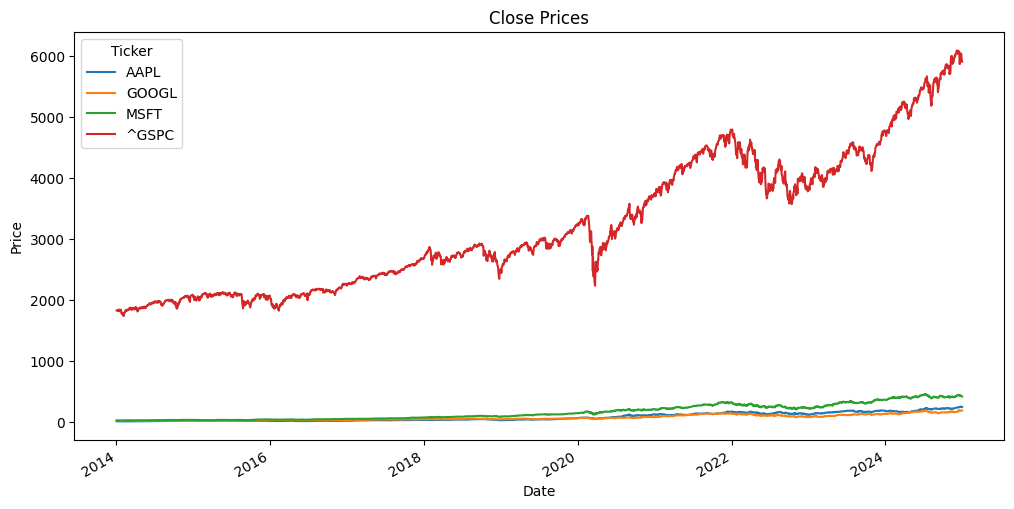


--- Plotting Close Prices with Moving Averages ---


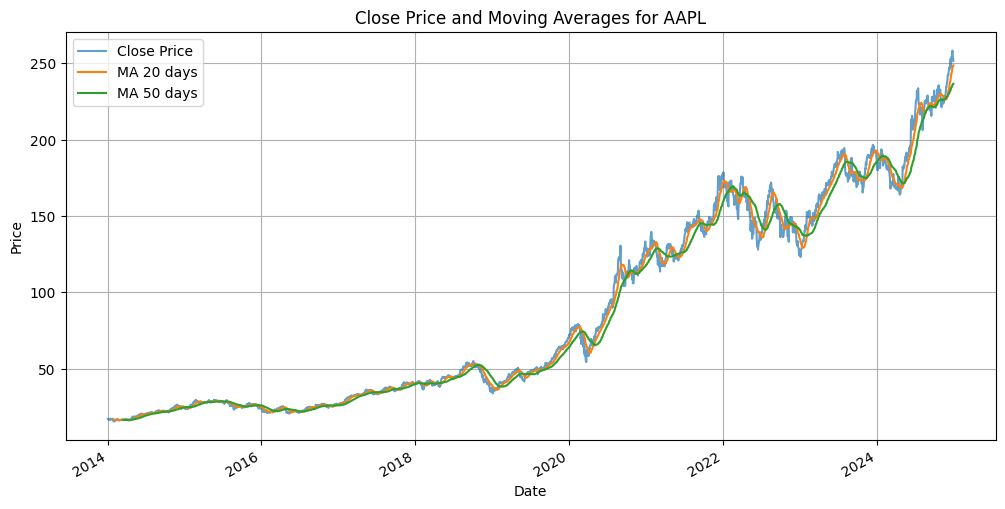

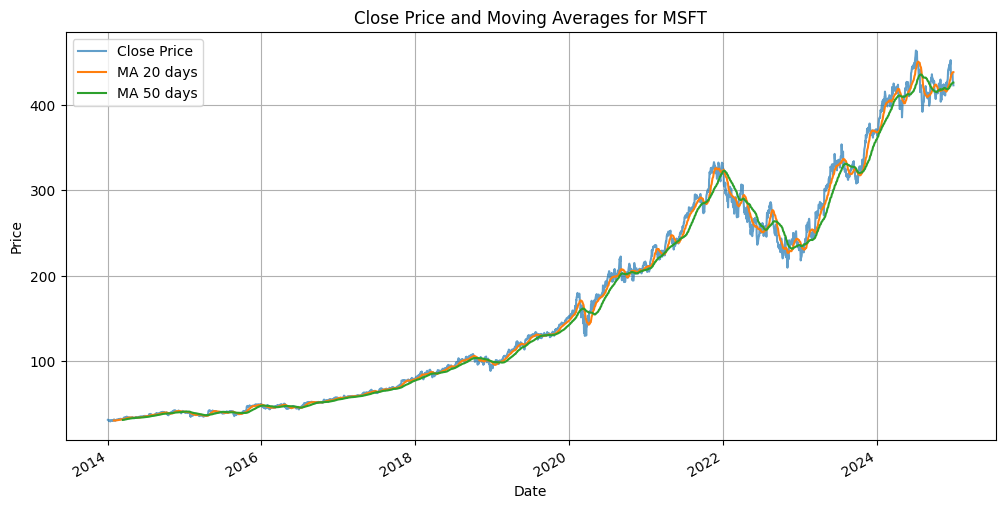

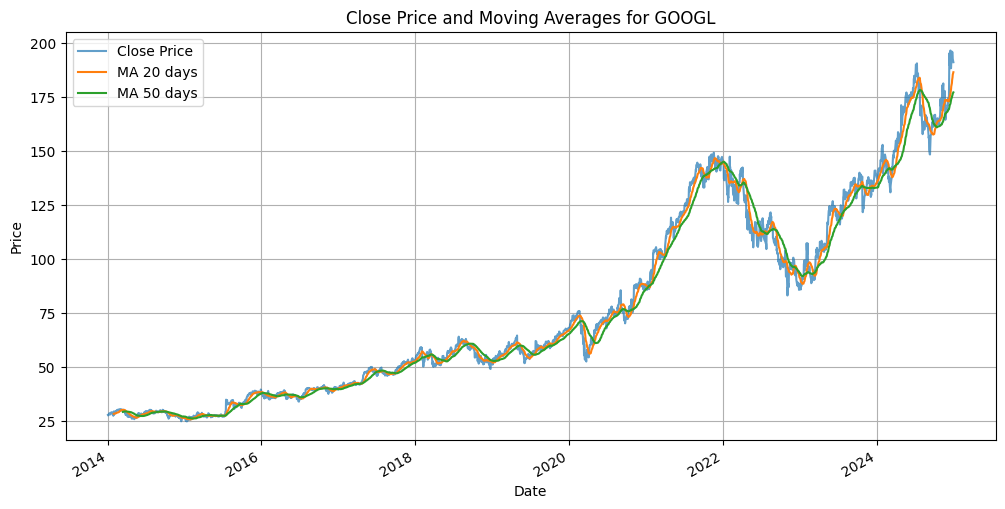

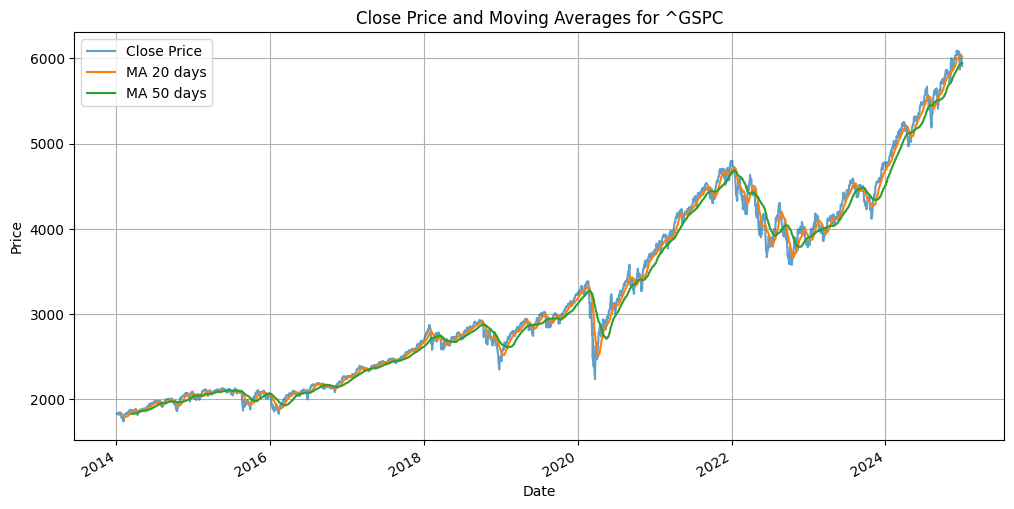

In [8]:
if not close_data.empty:
    print("\n--- Plotting Close Prices ---")
    close_data.plot(figsize=(12, 6), title="Close Prices", subplots=False) # subplots=True для отдельных графиков
    plt.ylabel("Price")
    plt.legend(title='Ticker')
    plt.show()

if not close_data.empty:
    print("\n--- Plotting Close Prices with Moving Averages ---")
    short_window = 20  # Например, 20-дневное МА (~ month)
    long_window = 50   # Например, 50-дневное МА (~ quartal)

    for ticker in tickers_list:
        if ticker in close_data.columns:
            plt.figure(figsize=(12, 6))
            close_data[ticker].plot(label='Close Price', alpha=0.7)
            close_data[ticker].rolling(window=short_window).mean().plot(label=f'MA {short_window} days')
            close_data[ticker].rolling(window=long_window).mean().plot(label=f'MA {long_window} days')
            plt.title(f"Close Price and Moving Averages for {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Price")
            plt.legend()
            plt.grid(True)
            plt.show()

### 2.2. Statistical Properties of Returns


--- Plotting Daily Returns ---


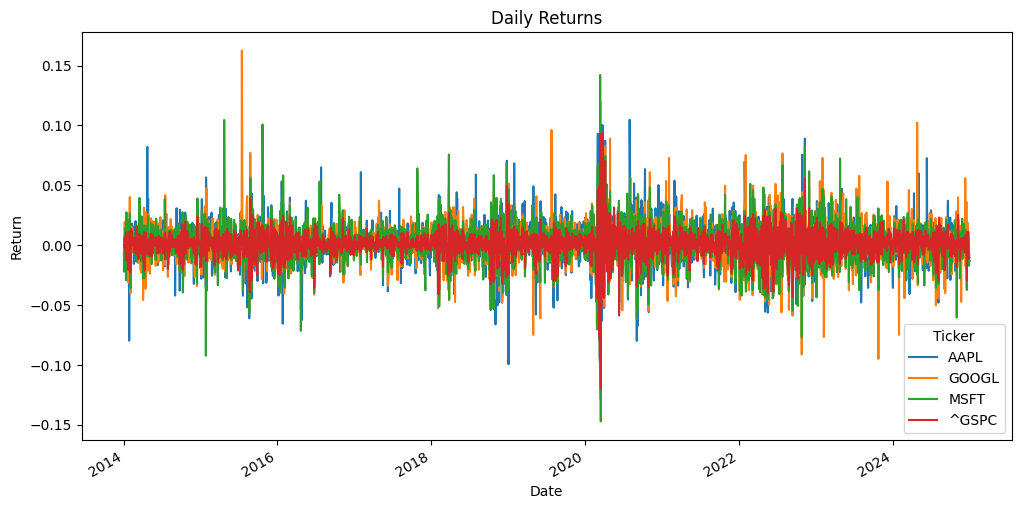


--- Plotting Histograms of Daily Returns ---


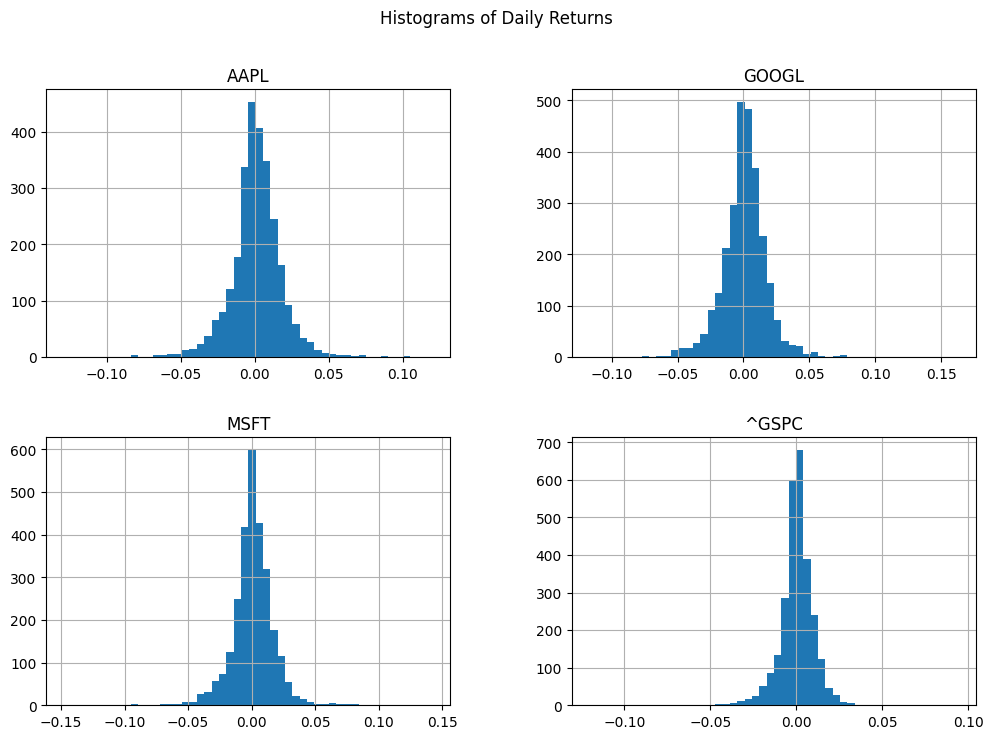

In [9]:
if 'daily_returns' in locals() and not daily_returns.empty: # Проверяем, существует ли daily_returns
    print("\n--- Plotting Daily Returns ---")
    daily_returns.plot(figsize=(12, 6), title="Daily Returns", subplots=False) # subplots=True для отдельных графиков
    plt.ylabel("Return")
    plt.show()

    print("\n--- Plotting Histograms of Daily Returns ---")
    daily_returns.hist(bins=50, figsize=(12, 8), sharex=False)
    plt.suptitle("Histograms of Daily Returns")
    plt.show()


--- Descriptive Statistics for Daily Returns ---
Ticker         AAPL        GOOGL         MSFT        ^GSPC
count   2766.000000  2766.000000  2766.000000  2766.000000
mean       0.001125     0.000852     0.001085     0.000483
std        0.017582     0.017573     0.016695     0.010922
min       -0.128647    -0.116341    -0.147390    -0.119841
25%       -0.007012    -0.007571    -0.006717    -0.003737
50%        0.001001     0.001142     0.000908     0.000653
75%        0.010116     0.009470     0.009664     0.005662
max        0.119808     0.162584     0.142169     0.093828

Skewness:
Ticker
AAPL    -0.011635
GOOGL    0.230104
MSFT     0.075650
^GSPC   -0.532558
dtype: float64

Kurtosis:
Ticker
AAPL      5.567478
GOOGL     6.688485
MSFT      7.904332
^GSPC    14.952258
dtype: float64

--- Seaborn Histograms and KDE for Daily Returns ---


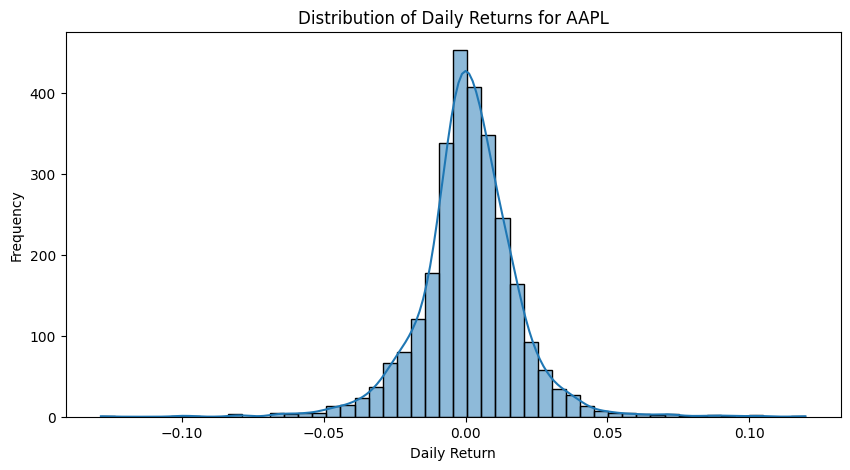

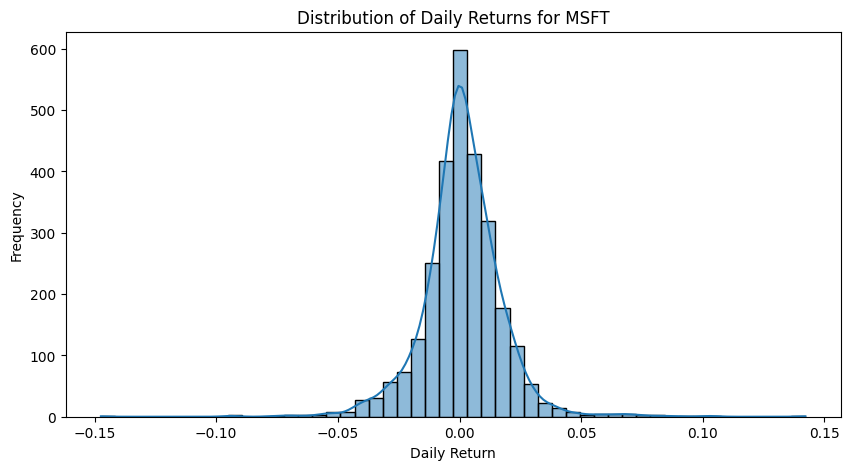

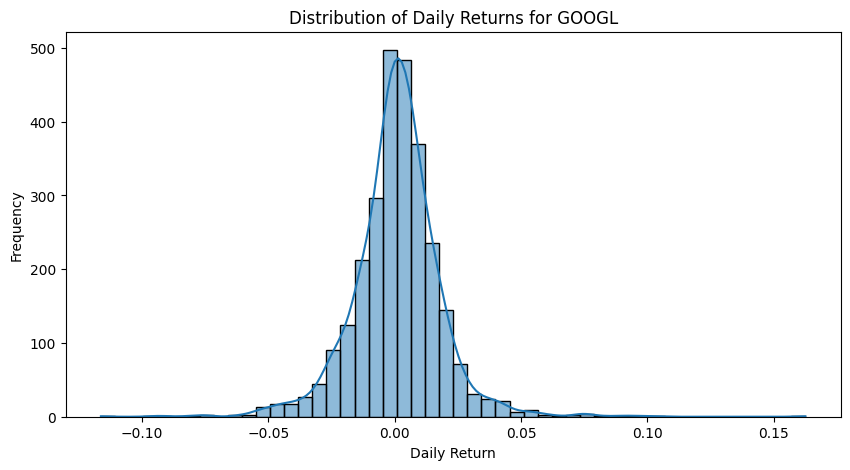

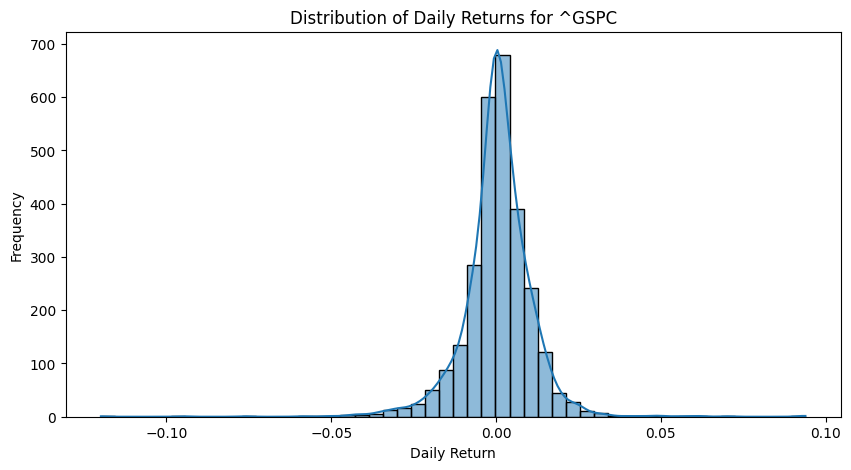

In [15]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Descriptive Statistics for Daily Returns ---")
    desc_stats = daily_returns.describe()
    print(desc_stats)

    # Можно добавить асимметрию (skewness) и эксцесс (kurtosis)
    print("\nSkewness:")
    print(daily_returns.skew())
    print("\nKurtosis:")
    print(daily_returns.kurt())
    print("\n--- Seaborn Histograms and KDE for Daily Returns ---")
    for ticker in tickers_list:
        if ticker in daily_returns.columns: # Убедимся, что тикер есть в данных
            plt.figure(figsize=(10, 5))
            sns.histplot(daily_returns[ticker], kde=True, bins=50)
            plt.title(f"Distribution of Daily Returns for {ticker}")
            plt.xlabel("Daily Return")
            plt.ylabel("Frequency")
            plt.show()


--- Seaborn Boxplots for Daily Returns Comparison ---


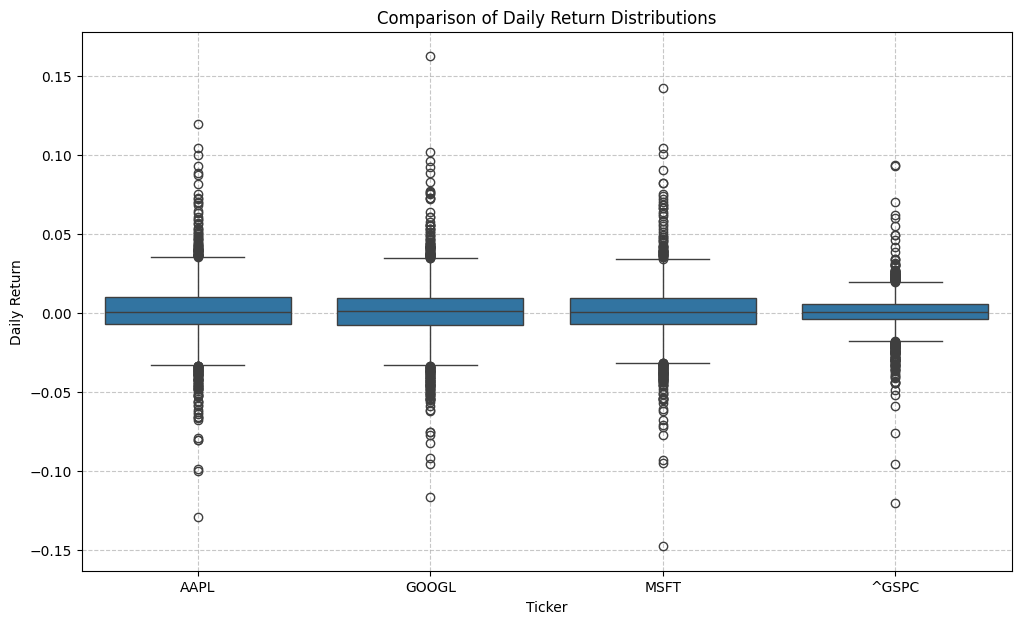

In [11]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Seaborn Boxplots for Daily Returns Comparison ---")
    # "Расплавим" DataFrame для удобства Seaborn
    # Это преобразует DataFrame из "широкого" формата (тикеры в столбцах)
    # в "длинный" формат (один столбец для тикеров, один для значений)
    melted_returns = daily_returns.melt(var_name='Ticker', value_name='Return')

    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Ticker', y='Return', data=melted_returns)
    plt.title("Comparison of Daily Return Distributions")
    plt.xlabel("Ticker")
    plt.ylabel("Daily Return")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Large kurtosis values (> 5) demonstrate the daily returns distributions are non-Gaussian and have havier tails.

### 2.3. Volatility analysis


--- Plotting Rolling Volatility ---


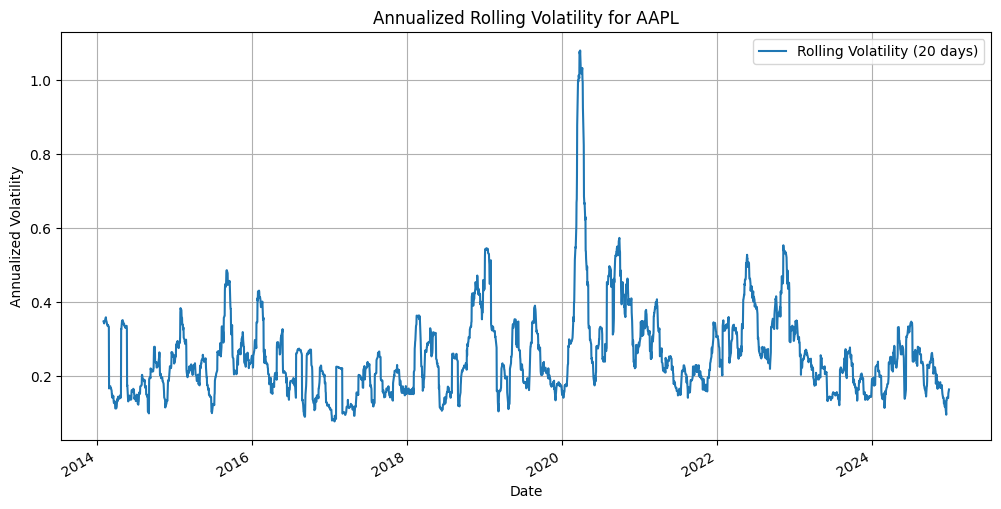

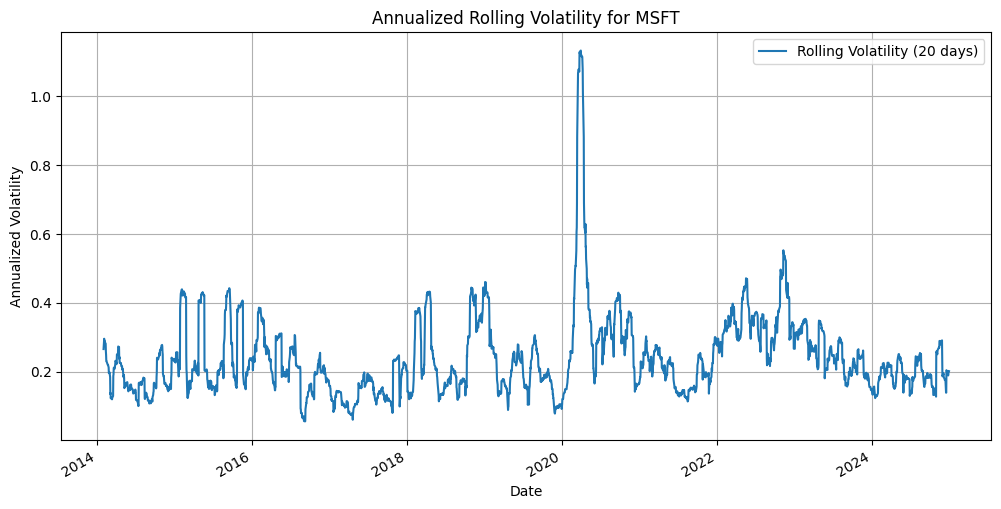

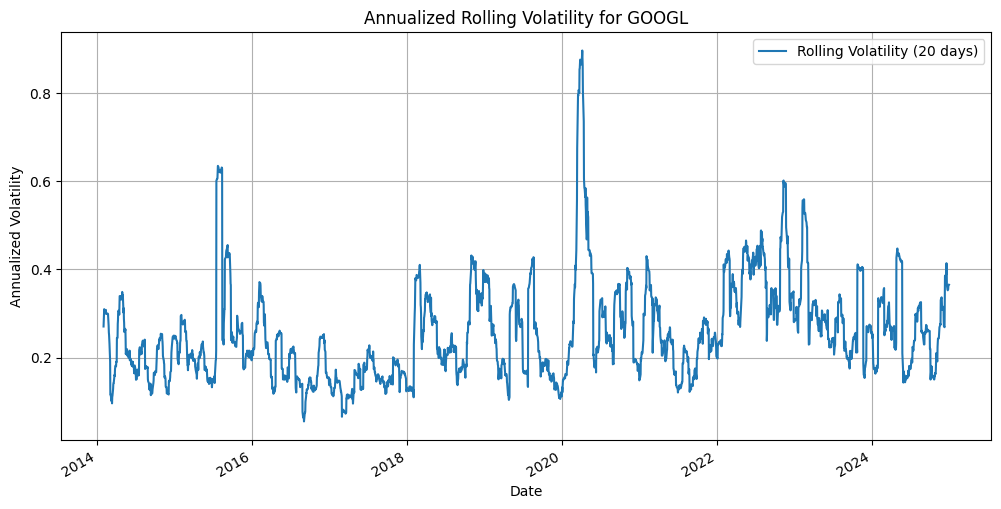

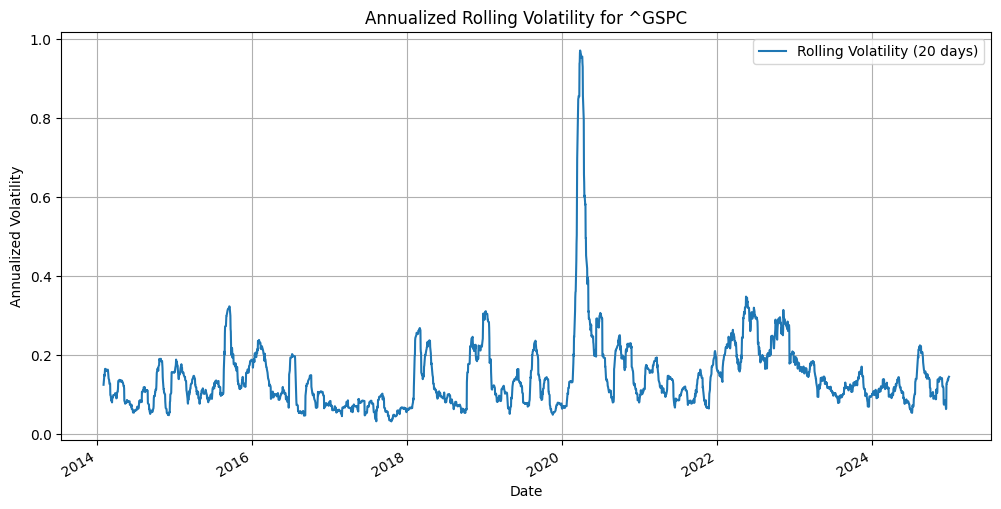

In [12]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Plotting Rolling Volatility ---")
    vol_window = 20 # Например, 20-дневная волатильность

    for ticker in tickers_list:
        if ticker in daily_returns.columns:
            rolling_std = daily_returns[ticker].rolling(window=vol_window).std() * (252**0.5) # Аннуализированная волатильность
            # Мы умножаем на корень из 252 (примерное число торговых дней в году),
            # чтобы аннуализировать дневную волатильность (привести к годовому масштабу).
            # Это стандартная практика, но можно отображать и просто дневную.

            plt.figure(figsize=(12, 6))
            rolling_std.plot(label=f'Rolling Volatility ({vol_window} days)')
            plt.title(f"Annualized Rolling Volatility for {ticker}")
            plt.xlabel("Date")
            plt.ylabel("Annualized Volatility")
            plt.legend()
            plt.grid(True)
            plt.show()


--- Autocorrelation of Squared Returns (Volatility Clustering Check) ---


<Figure size 1000x500 with 0 Axes>

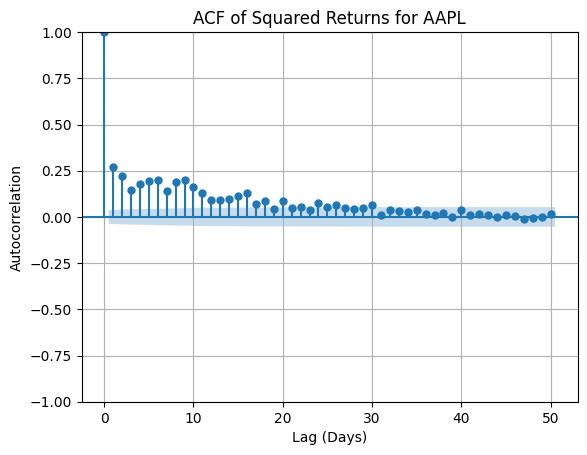

<Figure size 1000x500 with 0 Axes>

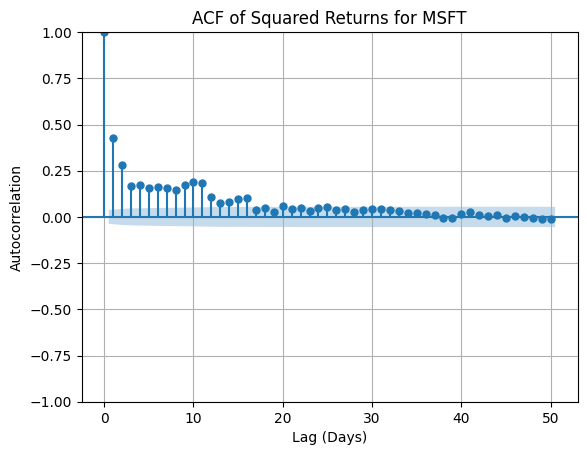

<Figure size 1000x500 with 0 Axes>

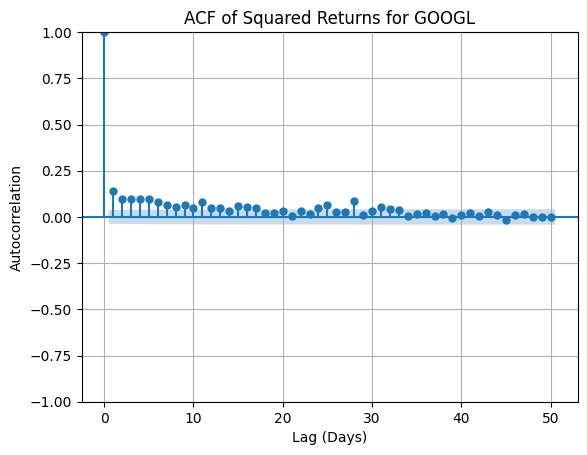

<Figure size 1000x500 with 0 Axes>

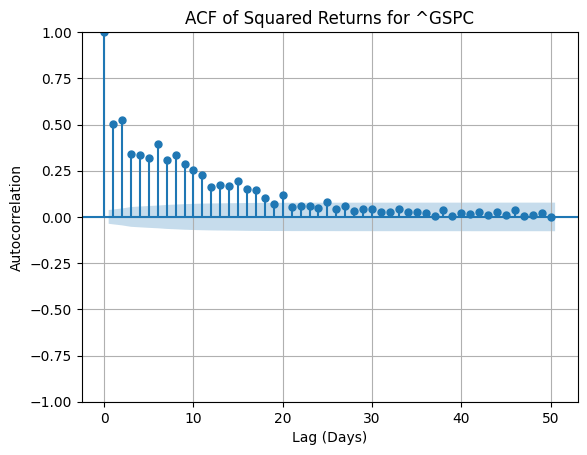

In [16]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Autocorrelation of Squared Returns (Volatility Clustering Check) ---")
    for ticker in tickers_list:
        if ticker in daily_returns.columns:
            squared_returns = daily_returns[ticker]**2
            plt.figure(figsize=(10, 5))
            plot_acf(squared_returns, lags=50, title=f'ACF of Squared Returns for {ticker}')
            # lags=50 означает, что мы смотрим автокорреляцию до 50-го лага (дня)
            plt.xlabel("Lag (Days)")
            plt.ylabel("Autocorrelation")
            plt.grid(True)
            plt.show()

Conclusion on volatility analysis.

# 3. Сравнительный анализ и анализ взаимосвязей

### 3.1. Сравнение профилей риск-доходность


--- Risk-Return Profile Analysis ---

Risk-Return Profile (Annualized):
        Annualized Return  Annualized Volatility
Ticker                                          
AAPL             0.283531               0.279101
GOOGL            0.214716               0.278957
MSFT             0.273520               0.265028
^GSPC            0.121776               0.173382


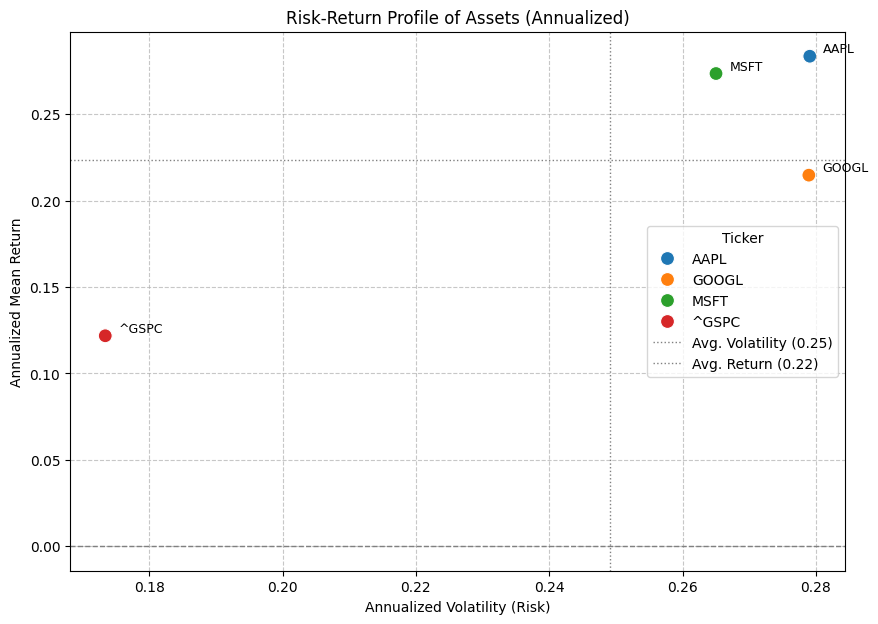

In [22]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Risk-Return Profile Analysis ---")

    # Рассчитываем среднюю дневную доходность и стандартное отклонение (волатильность)
    mean_daily_returns = daily_returns.mean()
    std_daily_returns = daily_returns.std()

    # Аннуализируем (приводим к годовым значениям)
    # Предполагаем 252 торговых дня в году
    annualized_returns = mean_daily_returns * 252
    annualized_volatility = std_daily_returns * np.sqrt(252)

    # Создаем DataFrame для наглядности
    risk_return_profile = pd.DataFrame({
        'Annualized Return': annualized_returns,
        'Annualized Volatility': annualized_volatility
    })

    print("\nRisk-Return Profile (Annualized):")
    print(risk_return_profile)

    # Визуализация: точечная диаграмма "средняя доходность vs. волатильность"
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Annualized Volatility', y='Annualized Return', data=risk_return_profile, s=100, hue=risk_return_profile.index, legend='full') # s=100 размер точек

    # Добавляем аннотации (названия тикеров) к точкам
    for i in range(risk_return_profile.shape[0]):
        ticker_name = risk_return_profile.index[i] # Получаем имя тикера (метку индекса)
        volatility_value = risk_return_profile['Annualized Volatility'].iloc[i] # Доступ по ПОЗИЦИИ i
        return_value = risk_return_profile['Annualized Return'].iloc[i]     # Доступ по ПОЗИЦИИ i
        
        plt.text(x=volatility_value+0.002, # небольшое смещение текста
                 y=return_value +0.002,
                 s=ticker_name, # имя тикера
                 fontdict=dict(color='black',size=9))

    plt.title('Risk-Return Profile of Assets (Annualized)')
    plt.xlabel('Annualized Volatility (Risk)')
    plt.ylabel('Annualized Mean Return')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0, color='grey', linestyle='--', lw=1) # Горизонтальная линия на уровне 0 доходности
    
    avg_vol = annualized_volatility.mean()
    avg_ret = annualized_returns.mean()
    plt.axvline(avg_vol, color='grey', linestyle=':', lw=1, label=f'Avg. Volatility ({avg_vol:.2f})')
    plt.axhline(avg_ret, color='grey', linestyle=':', lw=1, label=f'Avg. Return ({avg_ret:.2f})')
    
    plt.legend(title='Ticker')
    plt.show()

### 3.2


--- Correlation Matrix of Daily Returns ---
Ticker      AAPL     GOOGL      MSFT     ^GSPC
Ticker                                        
AAPL    1.000000  0.583078  0.660009  0.732150
GOOGL   0.583078  1.000000  0.699928  0.716918
MSFT    0.660009  0.699928  1.000000  0.788413
^GSPC   0.732150  0.716918  0.788413  1.000000


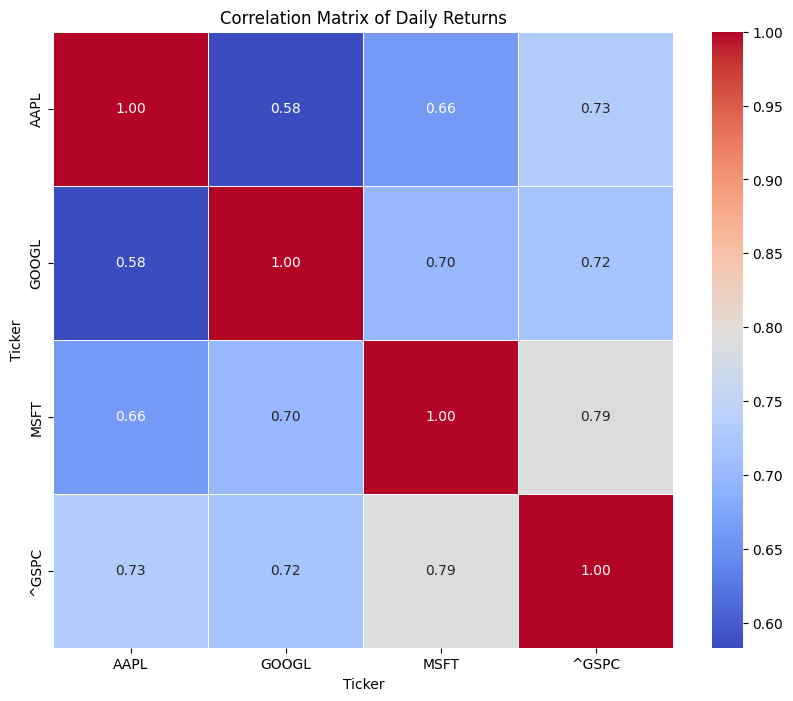

In [13]:
if 'daily_returns' in locals() and not daily_returns.empty:
    print("\n--- Correlation Matrix of Daily Returns ---")
    correlation_matrix = daily_returns.corr()
    print(correlation_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    # annot=True: отобразить значения корреляции на ячейках.
    # cmap='coolwarm': цветовая схема (от синего для отрицательной корреляции до красного для положительной).
    # fmt=".2f": форматировать значения до двух знаков после запятой.
    # linewidths: добавить линии между ячейками для лучшей читаемости.
    plt.title("Correlation Matrix of Daily Returns")
    plt.show()


--- Scatter Plots of Returns (vs S&P 500) ---


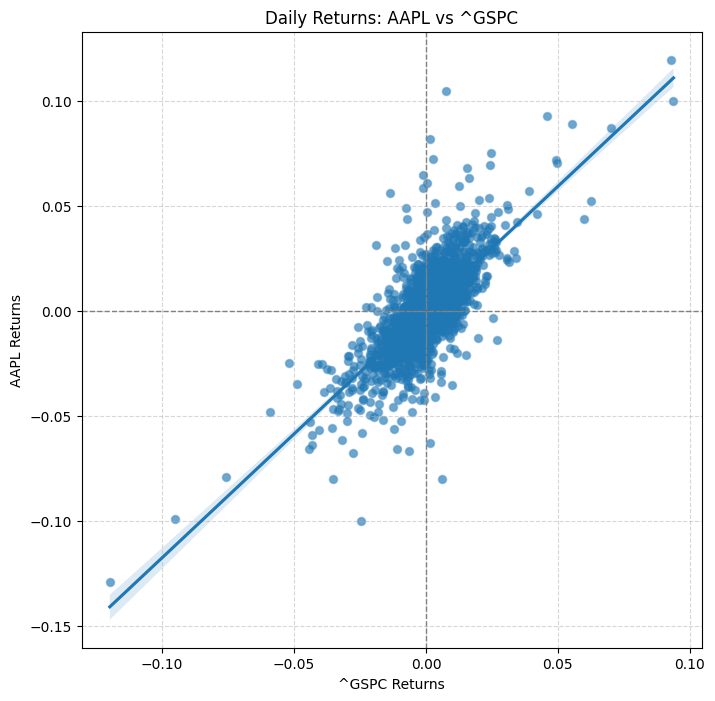

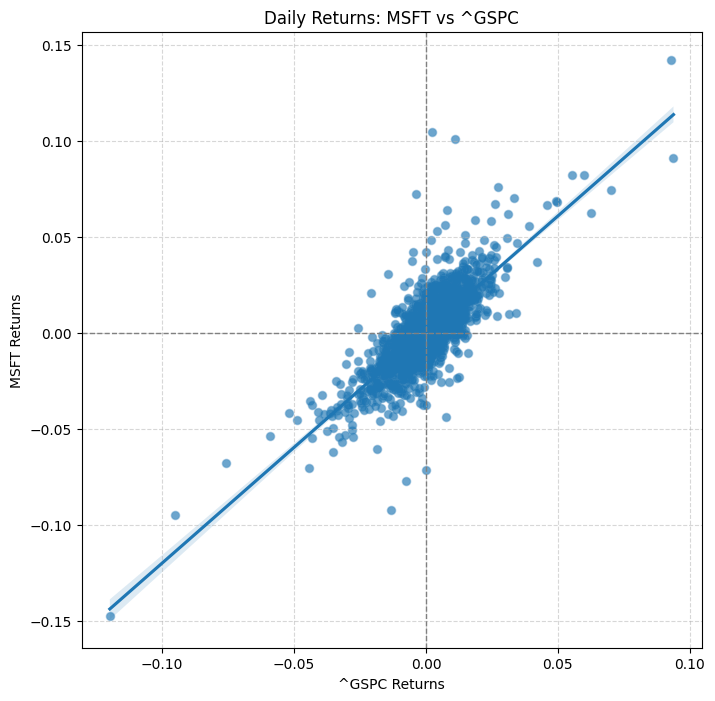

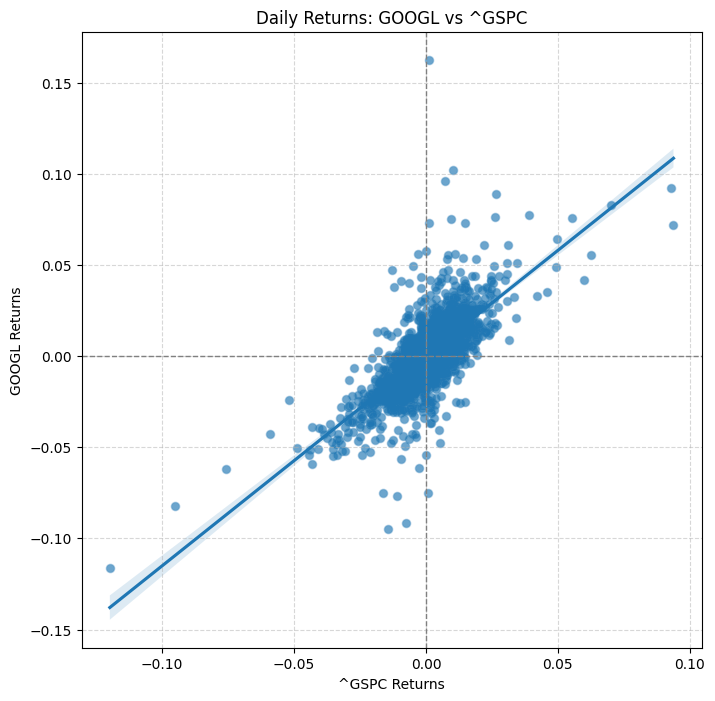

In [14]:
if 'daily_returns' in locals() and not daily_returns.empty and '^GSPC' in daily_returns.columns:
    print("\n--- Scatter Plots of Returns (vs S&P 500) ---")
    market_ticker = '^GSPC'
    for ticker in tickers_list:
        if ticker != market_ticker and ticker in daily_returns.columns:
            plt.figure(figsize=(8, 8))
            sns.scatterplot(x=daily_returns[market_ticker], y=daily_returns[ticker], alpha=0.5)
            # Можно добавить линию регрессии
            sns.regplot(x=daily_returns[market_ticker], y=daily_returns[ticker], scatter_kws={'alpha':0.3})
            plt.title(f"Daily Returns: {ticker} vs {market_ticker}")
            plt.xlabel(f"{market_ticker} Returns")
            plt.ylabel(f"{ticker} Returns")
            plt.axhline(0, color='grey', linestyle='--', lw=1)
            plt.axvline(0, color='grey', linestyle='--', lw=1)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()

### 3.3. Связь с рынком (Бета-анализ)


--- Beta Coefficient Calculation ---

Beta, Annualized Alpha, and R-squared values:
           Beta  Annualized Alpha  R-squared
AAPL   1.178578          0.140009   0.536044
MSFT   1.205153          0.126762   0.621596
GOOGL  1.153464          0.074252   0.513971


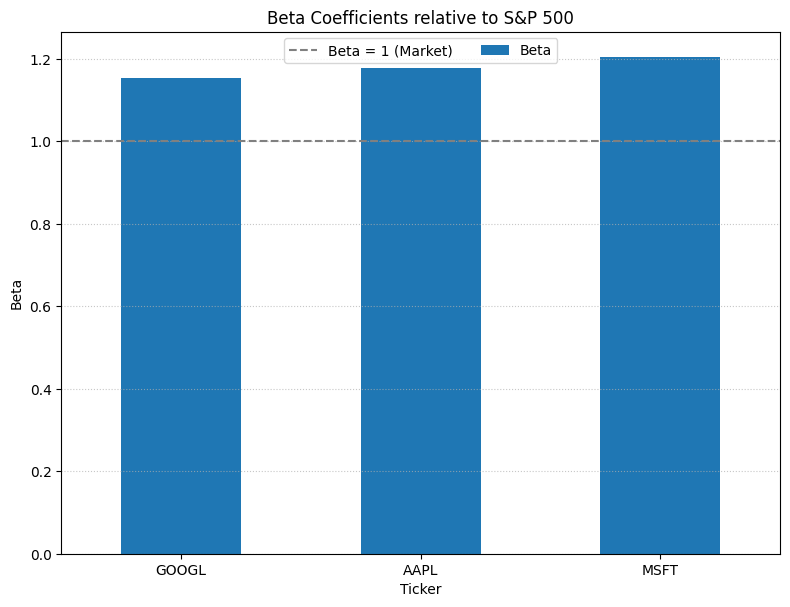

In [32]:
if 'daily_returns' in locals() and not daily_returns.empty and '^GSPC' in daily_returns.columns:
    print("\n--- Beta Coefficient Calculation ---")
    market_ticker = '^GSPC'
    market_returns = daily_returns[market_ticker].dropna() # Убедимся, что нет NaN

    beta_values = {}
    alpha_values = {} # Альфа - это пересечение, показывает избыточную доходность акции, не объясняемую рынком
    r_squared_values = {}

    for ticker in tickers_list:
        if ticker != market_ticker and ticker in daily_returns.columns:
            asset_returns = daily_returns[ticker].dropna()

            # Убедимся, что у нас одинаковые индексы (даты) для регрессии
            common_index = market_returns.index.intersection(asset_returns.index)
            X = market_returns.loc[common_index]
            y = asset_returns.loc[common_index]

            if len(X) > 1 and len(y) > 1: # Нужны хотя бы 2 точки для регрессии
                # linregress возвращает: slope, intercept, r_value, p_value, stderr
                slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

                beta_values[ticker] = slope
                alpha_values[ticker] = intercept * 252 # Аннуализируем альфу
                r_squared_values[ticker] = r_value**2
            else:
                print(f"Not enough data points for regression for {ticker} after aligning with market.")
                beta_values[ticker] = np.nan
                alpha_values[ticker] = np.nan
                r_squared_values[ticker] = np.nan


    beta_df = pd.DataFrame.from_dict(beta_values, orient='index', columns=['Beta'])
    alpha_df = pd.DataFrame.from_dict(alpha_values, orient='index', columns=['Annualized Alpha'])
    r_squared_df = pd.DataFrame.from_dict(r_squared_values, orient='index', columns=['R-squared'])

    beta_analysis_df = pd.concat([beta_df, alpha_df, r_squared_df], axis=1)

    # ... (код для расчета beta_analysis_df остается прежним) ...

    print("\nBeta, Annualized Alpha, and R-squared values:")
    print(beta_analysis_df)

    # Визуализация Беты (вертикальная столбчатая диаграмма)
    if not beta_analysis_df.empty:
        beta_to_plot = beta_analysis_df['Beta'].sort_values()

        plt.figure(figsize=(8, 6.5)) # Сделаем чуть выше, чтобы было место для легенды сверху
        beta_to_plot.plot(kind='bar', color='tab:blue', label='Beta')
        
        plt.title('Beta Coefficients relative to S&P 500')
        plt.xlabel('Ticker')
        plt.ylabel('Beta')
        
        plt.axhline(1.0, color='grey', linestyle='--', label='Beta = 1 (Market)')
        
        plt.xticks(rotation=0)
        
        # РАЗМЕЩЕНИЕ ЛЕГЕНДЫ НАД ГРАФИКОМ
        plt.legend(loc='lower center', # Якорь легенды - ее нижний центр
                   bbox_to_anchor=(0.5, 0.94), # Координаты (x,y) для якоря; 0.5 = по центру X, 1.02 = чуть выше верха графика
                   ncol=2, # Количество колонок в легенде (у нас 2 элемента, разместим их в ряд)
                   borderaxespad=0.) # Отступ от края осей (если 0, то близко к bbox_to_anchor)
        
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Оставляем немного места сверху для легенды перед применением tight_layout
                                              # rect=[left, bottom, right, top]
        plt.show()

Conclusion.
Бета показывает, как доходность акции реагирует на изменение доходности рынка.
Бета = 1: Акция движется вровень с рынком.
Бета > 1: Акция более волатильна, чем рынок (усиливает движения рынка).
Бета < 1: Акция менее волатильна, чем рынок.
Бета = 0: Движение акции не зависит от рынка.
Бета < 0: Акция движется в противофазе с рынком (редко для отдельных акций).

    Бета: Как описано выше.

    Альфа (аннуализированная): Показывает, насколько в среднем акция превзошла (положительная альфа) или уступила (отрицательная альфа) рынку, учитывая ее уровень систематического риска (Бету). Положительная альфа часто ищется инвесторами.

    R-квадрат (R-squared): Показывает, какая доля вариации доходности акции объясняется вариацией доходности рынка. Значение от 0 до 1. Чем ближе к 1, тем сильнее связь акции с рынком (и тем надежнее оценка Беты).